In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from brian2_loihi import *

In [2]:
"""
Define some parameters
"""

runtime = 1000
gen_spike_prob = 0.05

In [3]:
"""
Define neuron
"""

# Define a single neuron
neuron = LoihiNeuronGroup(
    N=1,
    refractory=2,
    threshold_v_mant=250,
    decay_v=4096,
    decay_I=4096
)

In [4]:
"""
Define input generators and spike times
"""

# Spiking generator for pre-synaptic spikes
rand_pre = np.random.rand(runtime)
times_pre = np.where(rand_pre < gen_spike_prob)[0]
indices_pre = np.zeros(len(times_pre)).astype(int)
gen_pre = LoihiSpikeGeneratorGroup(1, indices_pre, times_pre)

# Spiking generator for post-synaptic spikes
rand_post = np.random.rand(runtime)
times_post = np.where(rand_post < gen_spike_prob)[0]
indices_post = np.zeros(len(times_post)).astype(int)
gen_post = LoihiSpikeGeneratorGroup(1, indices_post, times_post)

In [5]:
"""
Define synapses and connect parts
"""

# Create an E-STDP learning rule and connect the pre-synaptic generator to the neuron
syn_plastic = LoihiSynapses(
    gen_pre,
    neuron,
    dw='2^-3*x1*y0 - 2^-3*y1*x0',
    imp_x1=127,
    tau_x1=10,
    imp_y1=127,
    tau_y1=10,
    sign_mode=synapse_sign_mode.EXCITATORY
)
syn_plastic.connect()
syn_plastic.w = 128

# Connect the post-synaptic generator with the neuron with a fixed connection
syn_static = LoihiSynapses(
    gen_post,
    neuron,
    sign_mode=synapse_sign_mode.EXCITATORY
)
syn_static.connect()
syn_static.w = 254

In [6]:
"""
Define probes using state/spike monitors
"""

# Define spike monitor for neuron
mon_s = LoihiSpikeMonitor(neuron)

# Define state monitor for plastic synapse
mon_w = LoihiStateMonitor(syn_plastic, 'w')

In [7]:
"""
Define a network and perform simulation
"""

# NOTE: It is important to use the LoihiNetwork,
#       using Brian's magic network is not provided
net = LoihiNetwork(
    neuron,
    gen_pre,
    gen_post,
    syn_plastic,
    syn_static,
    mon_s,
    mon_w
)

# Run the simulation
net.run(runtime, report='text')

Starting simulation at t=0. s for a duration of 1. s


1. s (100%) simulated in < 1s


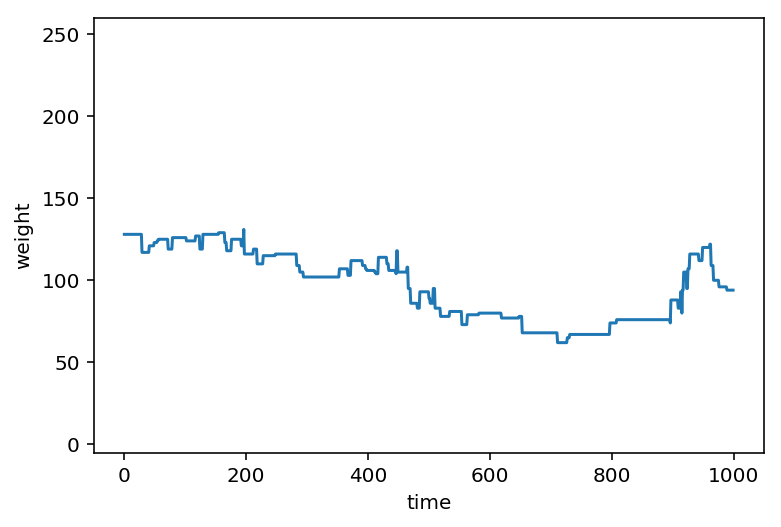

In [8]:
"""
Plot weight over time
"""

# Plot weight of the plastic synapse
plt.plot(mon_w.w[0])
plt.ylim((-5,260))
plt.xlabel('time')
plt.ylabel('weight')
pl = plt.show()

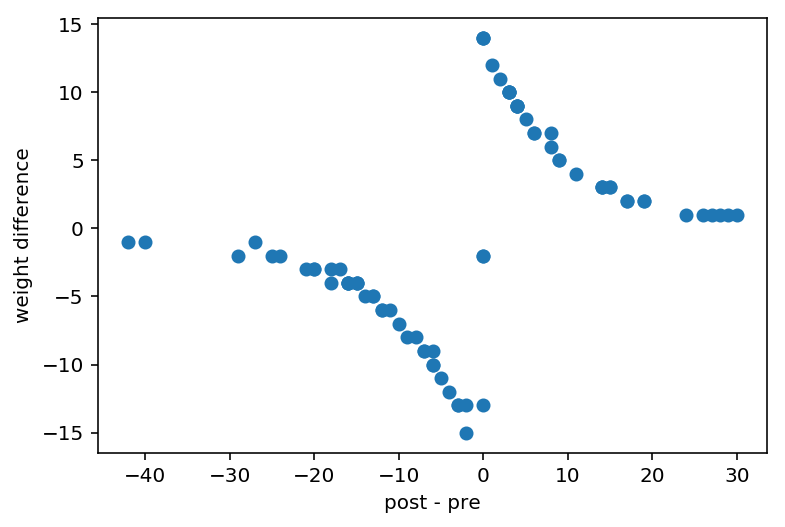

In [9]:
"""
Plot STDP learning window
"""

# Weight differences
wgt_diff = np.diff(mon_w.w[0])
# Indices of non-zero weight differences
wgt_diff_inds = wgt_diff.nonzero()[0]
# Closest pre and post spike times
closest = lambda times : np.array([ times[np.where(times <= t)][-1] for t in wgt_diff_inds+1 ])
# Pre/Post deltas
post_pre = closest(times_post) - closest(times_pre)

# Plot STDP learning window
plt.scatter(post_pre, wgt_diff[wgt_diff_inds])
plt.xlabel('post - pre')
plt.ylabel('weight difference')
pl = plt.show()